In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
# 2. Load the dataset
file_path = "E:\Dataset on Online Impulsive buying behaviour of E-paylater user and non E-paylater user\Dataset on Online Impulsive buying behaviour of E-paylater user and non E-paylater user\Raw-Data_Paylater-and-Non-Paylater-User.xlsx"  # adjust if needed
df = pd.read_excel(file_path)

# Strip whitespace from column names (important for SC3 / SC4)
df.columns = df.columns.str.strip()

df.head()
df.info()


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ONGC\AppData\Local\Temp\ipykernel_23788\3215458430.py:2: SyntaxWarning: invalid escape sequence '\D'
  file_path = "E:\Dataset on Online Impulsive buying behaviour of E-paylater user and non E-paylater user\Dataset on Online Impulsive buying behaviour of E-paylater user and non E-paylater user\Raw-Data_Paylater-and-Non-Paylater-User.xlsx"  # adjust if needed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 35 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   Gender                                                                         810 non-null    int64
 1   E-Paylater User Status                                                         810 non-null    int64
 2   Educational Background                                                         810 non-null    int64
 3   Year of Birth                                                                  810 non-null    int64
 4   Job Status                                                                     810 non-null    int64
 5   Monthly Income                                                                 810 non-null    int64
 6   Average monthly expenditure for online sho

In [5]:
print(df.shape)
print(df.columns)
df.describe()
df.isna().sum()


(810, 35)
Index(['Gender', 'E-Paylater User Status', 'Educational Background',
       'Year of Birth', 'Job Status', 'Monthly Income',
       'Average monthly expenditure for online shopping in relation to monthly income',
       'IBB1', 'IBB2', 'IBB3', 'IBB4', 'P1', 'P2', 'P3', 'P4', 'SI1', 'SI2',
       'SI3', 'SI4', 'SI5', 'SI6', 'H1', 'H2', 'H3', 'H4', 'SC1', 'SC2', 'SC3',
       'SC4', 'SC5', 'NE1', 'NE2', 'NE3', 'NE4', 'NE5'],
      dtype='object')


Gender                                                                           0
E-Paylater User Status                                                           0
Educational Background                                                           0
Year of Birth                                                                    0
Job Status                                                                       0
Monthly Income                                                                   0
Average monthly expenditure for online shopping in relation to monthly income    0
IBB1                                                                             0
IBB2                                                                             0
IBB3                                                                             0
IBB4                                                                             0
P1                                                                               0
P2  

In [9]:
# 1 = Male, 2 = Female
gender_map = {1: "Male", 2: "Female"}

# Assumption: 1 = Non-BNPL user, 2 = BNPL user (ever/current)
bnpl_map = {1: "Non-BNPL", 2: "BNPL-user"}

educ_map = {
    1: "Elementary/Junior HS",
    2: "Senior HS",
    3: "Diploma/Bachelor",
    4: "Postgraduate"
}

job_map = {
    1: "Student",
    2: "Civil Servant",
    3: "Employee",
    4: "Entrepreneur / Other"
}

income_map = {
    1: "<= 1,000,000 IDR",
    2: "1,000,001 - 2,500,000",
    3: "2,500,001 - 5,000,000",
    4: "5,000,001 - 7,500,000",
    5: "7,500,001 - 10,000,000",
    6: "> 10,000,000"
}

online_spend_map = {
    1: "0%",
    2: "< 20%",
    3: "21% - 40%",
    4: "41% - 60%",
    5: "61% - 80%",
    6: "81% - 100%",
    7: "> 100%"
}

df['gender_label'] = df['Gender'].map(gender_map)
df['bnpl_status'] = df['E-Paylater User Status'].map(bnpl_map)
df['educ_label'] = df['Educational Background'].map(educ_map)
df['job_label'] = df['Job Status'].map(job_map)
df['income_label'] = df['Monthly Income'].map(income_map)
df['online_spend_label'] = df['Average monthly expenditure for online shopping in relation to monthly income'].map(online_spend_map)

df[['Gender', 'gender_label', 'E-Paylater User Status', 'bnpl_status']].head()


,Gender,gender_label,E-Paylater User Status,bnpl_status
0,2,Female,1,Non-BNPL
1,1,Male,2,BNPL-user
2,1,Male,1,Non-BNPL
3,2,Female,2,BNPL-user
4,1,Male,2,BNPL-user


In [13]:
# Define item lists
ibb_items   = ['IBB1', 'IBB2', 'IBB3', 'IBB4']
promo_items = ['P1', 'P2', 'P3', 'P4']
si_items    = ['SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'SI6']
happy_items = ['H1', 'H2', 'H3', 'H4']
sc_items    = ['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
ne_items    = ['NE1', 'NE2', 'NE3', 'NE4', 'NE5']

# Quick sanity check: items exist
for item_list in [ibb_items, promo_items, si_items, happy_items, sc_items, ne_items]:
    for col in item_list:
        if col not in df.columns:
            print("Missing column:", col)


In [15]:
sc_reverse_items = ['SC3', 'SC4', 'SC5']

for col in sc_reverse_items:
    df[col + '_rev'] = 6 - df[col]   # 1 ↔ 5, 2 ↔ 4, 3 ↔ 3

# Define final SC items (SC1, SC2, and reversed 3–5)
sc_final_items = ['SC1', 'SC2', 'SC3_rev', 'SC4_rev', 'SC5_rev']


In [17]:
# Function to compute row-wise mean ignoring NaNs
def create_scale_mean(data, cols, new_name):
    data[new_name] = data[cols].mean(axis=1)
    return data

df = create_scale_mean(df, ibb_items,   'IBB')
df = create_scale_mean(df, promo_items, 'PROMO')
df = create_scale_mean(df, si_items,    'SI')
df = create_scale_mean(df, happy_items, 'HAPPY')
df = create_scale_mean(df, sc_final_items, 'SC')
df = create_scale_mean(df, ne_items,    'NE')

df[['IBB', 'PROMO', 'SI', 'HAPPY', 'SC', 'NE']].describe()


,IBB,PROMO,SI,HAPPY,SC,NE
count,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000
mean,2.756173,2.334877,2.357407,3.496605,3.358272,3.423457
std,0.879810,1.118298,0.993422,0.833424,0.599123,0.890268
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.500000,3.000000,3.000000,2.800000
50%,2.750000,2.000000,2.166667,3.750000,3.400000,3.400000
75%,3.500000,3.250000,3.000000,4.000000,3.800000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [19]:
def cronbach_alpha(df_items):
    """
    df_items: a DataFrame with only the items for one construct
    """
    df_items = df_items.dropna(axis=0)  # drop rows with missing
    k = df_items.shape[1]
    item_variances = df_items.var(axis=0, ddof=1)
    total_scores = df_items.sum(axis=1)
    total_variance = total_scores.var(ddof=1)
    alpha = (k / (k - 1)) * (1 - item_variances.sum() / total_variance)
    return alpha


In [21]:
alpha_results = {}

alpha_results['IBB']   = cronbach_alpha(df[ibb_items])
alpha_results['PROMO'] = cronbach_alpha(df[promo_items])
alpha_results['SI']    = cronbach_alpha(df[si_items])
alpha_results['HAPPY'] = cronbach_alpha(df[happy_items])
alpha_results['SC']    = cronbach_alpha(df[sc_final_items])
alpha_results['NE']    = cronbach_alpha(df[ne_items])

alpha_results


{'IBB': 0.7699319023797183,
 'PROMO': 0.9456718160268399,
 'SI': 0.9492071702279041,
 'HAPPY': 0.9202097404279388,
 'SC': 0.6118481277344029,
 'NE': 0.8499772993068098}

In [23]:
scale_vars = ['IBB', 'PROMO', 'SI', 'HAPPY', 'SC', 'NE']

df[scale_vars].describe().T


,count,mean,std,min,25%,50%,75%,max
IBB,810.0,2.756173,0.879810,1.0,2.0,2.750000,3.50,5.0
PROMO,810.0,2.334877,1.118298,1.0,1.0,2.000000,3.25,5.0
SI,810.0,2.357407,0.993422,1.0,1.5,2.166667,3.00,5.0
HAPPY,810.0,3.496605,0.833424,1.0,3.0,3.750000,4.00,5.0
SC,810.0,3.358272,0.599123,1.0,3.0,3.400000,3.80,5.0
NE,810.0,3.423457,0.890268,1.0,2.8,3.400000,4.00,5.0


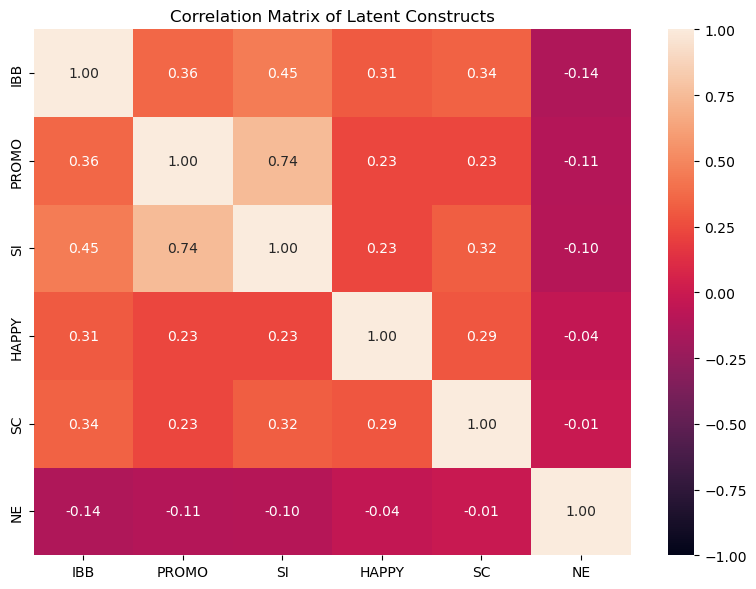

In [25]:
corr = df[scale_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Latent Constructs")
plt.tight_layout()
plt.show()


In [27]:
# Check group sizes
df['bnpl_status'].value_counts()


bnpl_status
Non-BNPL     606
BNPL-user    204
Name: count, dtype: int64

In [29]:
group_means = df.groupby('bnpl_status')[scale_vars].mean()
group_means


,IBB,PROMO,SI,HAPPY,SC,NE
bnpl_status,,,,,,
BNPL-user,3.014706,3.214461,3.019608,3.567402,3.419608,3.366667
Non-BNPL,2.669142,2.038779,2.134488,3.472772,3.337624,3.442574


In [31]:
from scipy.stats import ttest_ind

bnpl = df[df['bnpl_status'] == 'BNPL-user']
non_bnpl = df[df['bnpl_status'] == 'Non-BNPL']

for var in scale_vars:
    t_stat, p_val = ttest_ind(bnpl[var].dropna(),
                              non_bnpl[var].dropna(),
                              equal_var=False)  # Welch's t-test
    print(f"{var}: t = {t_stat:.3f}, p = {p_val:.4f}")


IBB: t = 4.836, p = 0.0000
PROMO: t = 14.451, p = 0.0000
SI: t = 11.533, p = 0.0000
HAPPY: t = 1.476, p = 0.1406
SC: t = 1.636, p = 0.1027
NE: t = -1.051, p = 0.2938


In [33]:
# Create a working dataset with no missing values for these variables
model_data = df[['IBB', 'PROMO', 'SI', 'HAPPY', 'SC', 'NE',
                 'Gender', 'Year of Birth', 'Monthly Income',
                 'E-Paylater User Status']].dropna()

# Optional: center predictors
for col in ['PROMO', 'SI', 'HAPPY', 'SC', 'NE']:
    model_data[col + '_c'] = model_data[col] - model_data[col].mean()


In [35]:
# Regression: IBB ~ PROMO + SI + HAPPY + SC + NE + controls
formula = """
IBB ~ PROMO_c + SI_c + HAPPY_c + SC_c + NE_c
      + Gender + Year_of_Birth + Monthly_Income + E_Paylater_User_Status
""".replace("\n", " ").replace("  ", " ")

# Rename columns for formula compatibility
model_data = model_data.rename(columns={
    'Year of Birth': 'Year_of_Birth',
    'Monthly Income': 'Monthly_Income',
    'E-Paylater User Status': 'E_Paylater_User_Status'
})

model = smf.ols(formula=formula, data=model_data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    IBB   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     35.27
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           1.24e-52
Time:                        18:54:18   Log-Likelihood:                -909.78
No. Observations:                 810   AIC:                             1840.
Df Residuals:                     800   BIC:                             1887.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [37]:
# Mediator: HAPPY ~ PROMO + SI
med_model = smf.ols("HAPPY_c ~ PROMO_c + SI_c", data=model_data).fit()
print(med_model.summary())

# Outcome: IBB ~ PROMO + SI + HAPPY
out_model = smf.ols("IBB ~ PROMO_c + SI_c + HAPPY_c", data=model_data).fit()
print(out_model.summary())


                            OLS Regression Results                            
Dep. Variable:                HAPPY_c   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     26.40
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           7.83e-12
Time:                        18:54:22   Log-Likelihood:                -975.58
No. Observations:                 810   AIC:                             1957.
Df Residuals:                     807   BIC:                             1971.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.949e-17      0.028   1.04e-15      1.0

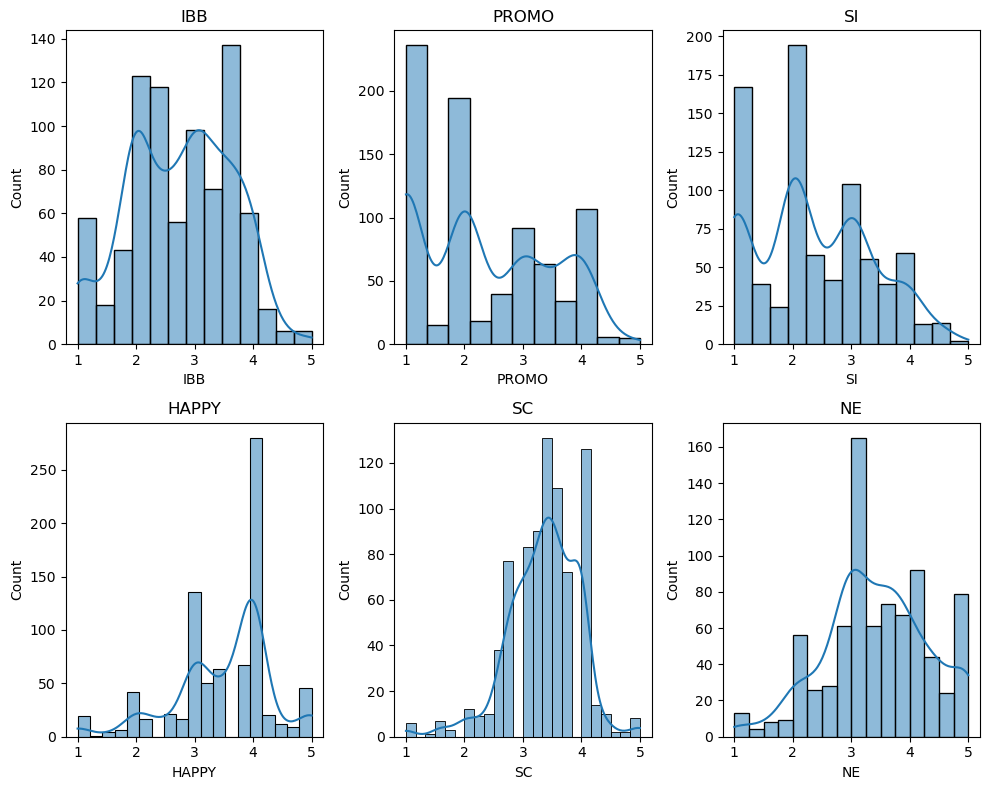

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

scale_vars = ['IBB', 'PROMO', 'SI', 'HAPPY', 'SC', 'NE']

plt.figure(figsize=(10, 8))
for i, var in enumerate(scale_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[var].dropna(), kde=True)
    plt.title(var)
plt.tight_layout()
plt.show()



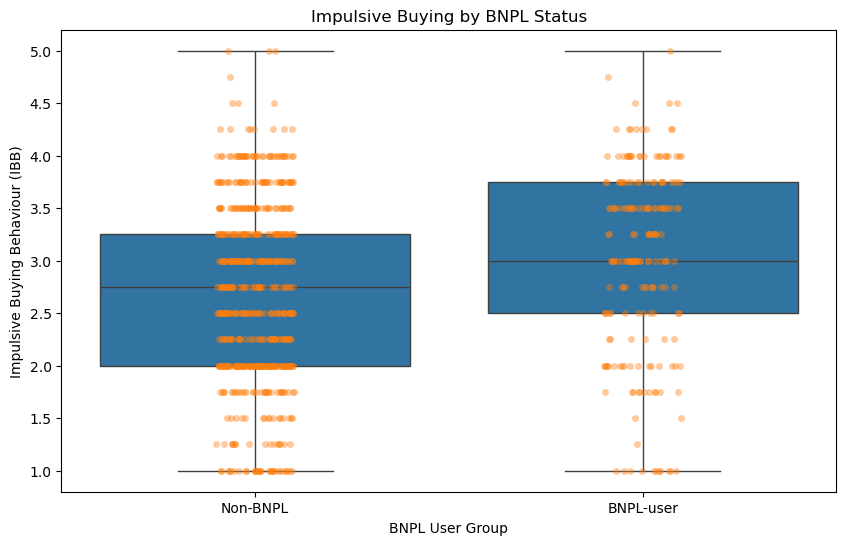

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='bnpl_status', y='IBB')
sns.stripplot(data=df, x='bnpl_status', y='IBB', alpha=0.4)
plt.title("Impulsive Buying by BNPL Status")
plt.xlabel("BNPL User Group")
plt.ylabel("Impulsive Buying Behaviour (IBB)")
plt.show()


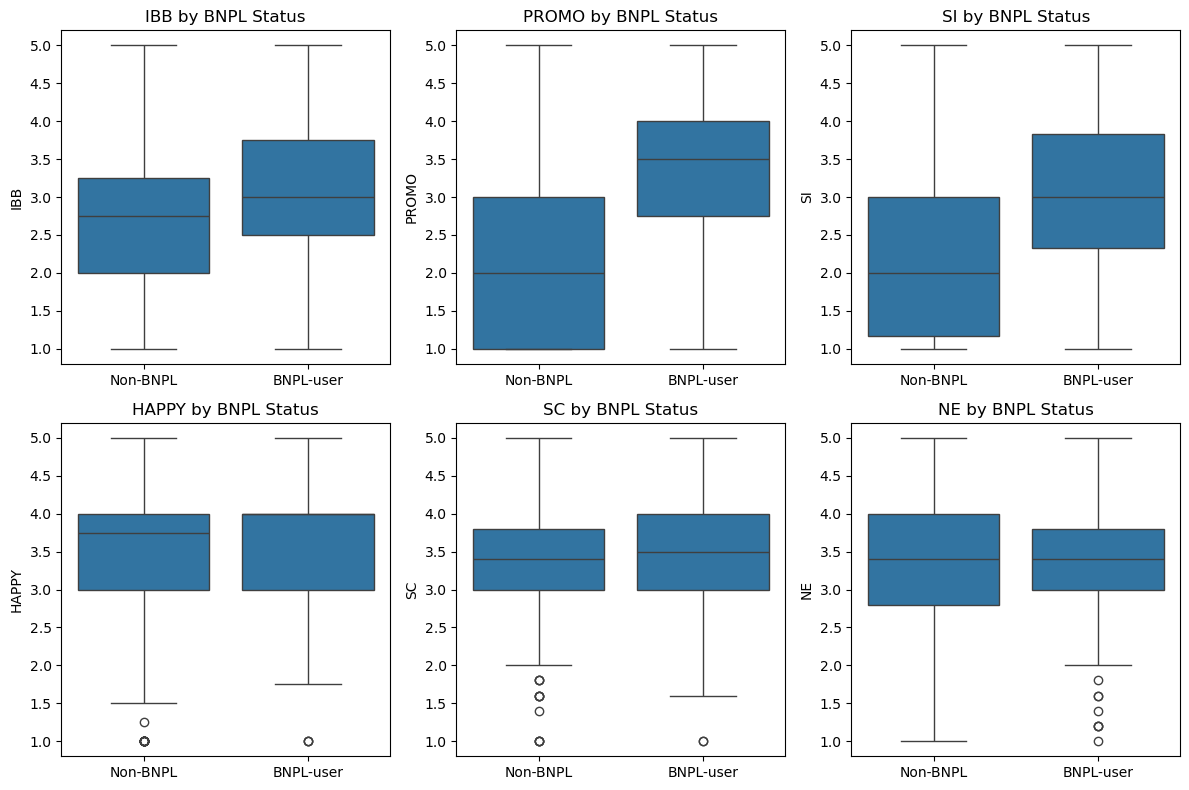

In [43]:
plt.figure(figsize=(12, 8))
for i, var in enumerate(scale_vars, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='bnpl_status', y=var)
    plt.title(f"{var} by BNPL Status")
    plt.xlabel("")
plt.tight_layout()
plt.show()


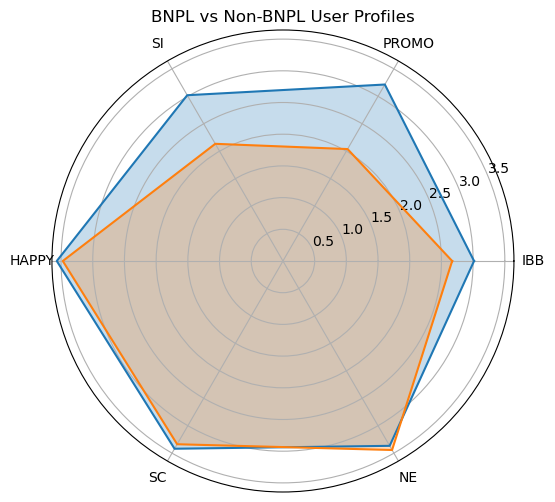

In [45]:
import numpy as np

group_means = df.groupby('bnpl_status')[scale_vars].mean()

labels = scale_vars
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close loop

def make_radar(values, label):
    values = values.tolist()
    values += values[:1]
    return values

bnpl_vals = make_radar(group_means.loc['BNPL-user'], 'BNPL')
non_vals  = make_radar(group_means.loc['Non-BNPL'], 'Non')

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, bnpl_vals)
ax.fill(angles, bnpl_vals, alpha=0.25)

ax.plot(angles, non_vals)
ax.fill(angles, non_vals, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("BNPL vs Non-BNPL User Profiles")
plt.show()


In [51]:
cfa_model_desc = """
IBB =~ IBB1 + IBB2 + IBB3 + IBB4
PROMO =~ P1 + P2 + P3 + P4
SI =~ SI1 + SI2 + SI3 + SI4 + SI5 + SI6
HAPPY =~ H1 + H2 + H3 + H4
SC =~ SC1 + SC2 + SC3_rev + SC4_rev + SC5_rev
NE =~ NE1 + NE2 + NE3 + NE4 + NE5
"""


In [53]:
ibb_items   = ['IBB1', 'IBB2', 'IBB3', 'IBB4']
promo_items = ['P1', 'P2', 'P3', 'P4']
si_items    = ['SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'SI6']
happy_items = ['H1', 'H2', 'H3', 'H4']
ne_items    = ['NE1', 'NE2', 'NE3', 'NE4', 'NE5']

cfa_cols = (
    ibb_items + promo_items + si_items + happy_items +
    ['SC1', 'SC2', 'SC3_rev', 'SC4_rev', 'SC5_rev'] +
    ne_items
)

# Keep only the columns we need and drop rows with any missing CFA item
cfa_df = df[cfa_cols].dropna()
print("CFA data shape:", cfa_df.shape)


CFA data shape: (810, 28)


In [55]:
model = Model(cfa_model_desc)
res = model.fit(cfa_df)

print("Fit result:", res)


Fit result: Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 4.072
Number of iterations: 66
Params: 1.128 0.623 0.908 1.014 0.972 1.061 0.933 1.034 1.055 0.939 0.942 1.134 1.038 1.113 0.701 0.006 -0.036 -0.116 0.980 1.017 0.915 0.975 0.227 0.206 0.288 0.161 0.556 0.225 -0.029 0.189 0.726 -0.133 0.432 0.520 0.435 0.924 0.821 0.705 -0.098 0.648 0.480 0.528 0.630 0.676 0.334 0.291 0.258 0.203 1.153 0.214 0.384 -0.119 0.825 0.647 0.060 -0.070 0.068 -0.029 -0.026 0.000 0.399 0.953 0.993 1.257 0.969 0.333 0.421 0.135 0.237 0.268 0.383


In [59]:
stats = calc_stats(model)
stats


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,335,378,3298.05801,0.0,17379.992207,0.825723,0.810238,0.785881,0.810238,0.803353,0.104562,133.856647,467.346078,4.071677


In [61]:
params = model.inspect(std_est=True)
print(params.head())
print(params.columns)


   lval op   rval  Estimate  Est. Std  Std. Err    z-value p-value
0  IBB1  ~    IBB  1.000000  0.763158         -          -       -
1  IBB2  ~    IBB  1.127841  0.824289  0.055474  20.330933     0.0
2  IBB3  ~    IBB  0.622793  0.483285  0.049168  12.666502     0.0
3  IBB4  ~    IBB  0.907590  0.649041  0.053245  17.045508     0.0
4    P1  ~  PROMO  1.000000  0.880457         -          -       -
Index(['lval', 'op', 'rval', 'Estimate', 'Est. Std', 'Std. Err', 'z-value',
       'p-value'],
      dtype='object')


In [63]:
std_cols = [c for c in params.columns if 'std' in c.lower()]
std_cols


['Est. Std', 'Std. Err']

In [83]:
# Standardized parameters
params = model.inspect(std_est=True)

# In your version: loadings use op "~" between latent → indicator
loadings = params[
    (params['op'] == '~') &
    (params['rval'].str.contains('IBB|P|SI|H|SC|NE'))
][['lval','rval','Est. Std']].copy()

loadings.rename(columns={'Est. Std':'loading'}, inplace=True)

# Sort by weakest item first
loadings_sorted = loadings.sort_values(by='loading')
loadings_sorted


,lval,rval,loading
22,SC5_rev,SC,-0.083159
21,SC4_rev,SC,-0.028966
20,SC3_rev,SC,0.004534
2,IBB3,IBB,0.483285
3,IBB4,IBB,0.649041
19,SC2,SC,0.665786
26,NE4,NE,0.695464
27,NE5,NE,0.705586
23,NE1,NE,0.721855
25,NE3,NE,0.761504


In [93]:
# Create parcels (mean of grouped items)

# PROMO: 4 items → 2 parcels
df['PROMO_p1'] = df[['P1', 'P2']].mean(axis=1)
df['PROMO_p2'] = df[['P3', 'P4']].mean(axis=1)

# SI: 6 items → 3 parcels (2+2+2)
df['SI_p1'] = df[['SI1', 'SI2']].mean(axis=1)
df['SI_p2'] = df[['SI3', 'SI4']].mean(axis=1)
df['SI_p3'] = df[['SI5', 'SI6']].mean(axis=1)

# HAPPY: 4 items → 2 parcels
df['HAPPY_p1'] = df[['H1', 'H2']].mean(axis=1)
df['HAPPY_p2'] = df[['H3', 'H4']].mean(axis=1)

# NE: 5 items → 2 parcels (3+2)
df['NE_p1'] = df[['NE1', 'NE2', 'NE3']].mean(axis=1)
df['NE_p2'] = df[['NE4', 'NE5']].mean(axis=1)

# IBB remains item level (3 indicators)


In [95]:
cfa_model_parcels = """
IBB =~ IBB1 + IBB2 + IBB4
PROMO =~ PROMO_p1 + PROMO_p2
SI =~ SI_p1 + SI_p2 + SI_p3
HAPPY =~ HAPPY_p1 + HAPPY_p2
NE =~ NE_p1 + NE_p2
"""


In [97]:
model_parcel = Model(cfa_model_parcels)
model_parcel.fit(df.dropna())

stats_parcel = calc_stats(model_parcel)
stats_parcel


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,44,66,295.479493,0.0,6979.876793,0.963627,0.957667,0.9365,0.957667,0.94544,0.084053,67.270421,226.969585,0.364789


In [99]:
from semopy import Model, calc_stats

sem_model_desc = """
# Measurement Model (parceled)
IBB =~ IBB1 + IBB2 + IBB4
PROMO =~ PROMO_p1 + PROMO_p2
SI =~ SI_p1 + SI_p2 + SI_p3
HAPPY =~ HAPPY_p1 + HAPPY_p2
NE =~ NE_p1 + NE_p2

# Structural Model (S-O-R)
HAPPY ~ PROMO + SI
NE ~ PROMO + SI
IBB ~ HAPPY + NE + PROMO + SI
"""

sem_model = Model(sem_model_desc)
sem_model.fit(df.dropna())

sem_stats = calc_stats(sem_model)
sem_params = sem_model.inspect(std_est=True)

sem_stats, sem_params


(       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline       CFI  \
 Value   45            66  296.444376           0.0    6979.876793  0.963632   
 
             GFI      AGFI       NFI      TLI     RMSEA        AIC         BIC  \
 Value  0.957529  0.937709  0.957529  0.94666  0.083108  65.268039  220.270169   
 
          LogLik  
 Value  0.365981  ,
         lval  op      rval  Estimate  Est. Std  Std. Err    z-value   p-value
 0      HAPPY   ~     PROMO  0.172790  0.207303  0.049408    3.49723   0.00047
 1      HAPPY   ~        SI  0.078942  0.086990  0.053908   1.464396  0.143086
 2         NE   ~     PROMO -0.122120 -0.134607  0.055926  -2.183595  0.028992
 3         NE   ~        SI -0.019658 -0.019901  0.061015  -0.322174  0.747321
 4        IBB   ~     HAPPY  0.248448  0.251101  0.038691   6.421388       0.0
 5        IBB   ~        NE -0.117278 -0.129014  0.039152  -2.995447   0.00274
 6        IBB   ~     PROMO  0.007600  0.009215  0.048768   0.155836  0.876162
 

In [101]:
# Extract standardized parameters
paths = sem_params[['lval','op','rval','Est. Std','p-value']]
print(paths)

# Calculate indirect effects manually
indirect_PROMO_HAPPY_IBB = (
    paths[(paths['lval']=='HAPPY') & (paths['rval']=='PROMO')]['Est. Std'].values[0] *
    paths[(paths['lval']=='IBB') & (paths['rval']=='HAPPY')]['Est. Std'].values[0]
)

indirect_PROMO_NE_IBB = (
    paths[(paths['lval']=='NE') & (paths['rval']=='PROMO')]['Est. Std'].values[0] *
    paths[(paths['lval']=='IBB') & (paths['rval']=='NE')]['Est. Std'].values[0]
)

indirect_PROMO_HAPPY_IBB, indirect_PROMO_NE_IBB


        lval  op      rval  Est. Std   p-value
0      HAPPY   ~     PROMO  0.207303   0.00047
1      HAPPY   ~        SI  0.086990  0.143086
2         NE   ~     PROMO -0.134607  0.028992
3         NE   ~        SI -0.019901  0.747321
4        IBB   ~     HAPPY  0.251101       0.0
5        IBB   ~        NE -0.129014   0.00274
6        IBB   ~     PROMO  0.009215  0.876162
7        IBB   ~        SI  0.440370       0.0
8       IBB1   ~       IBB  0.766555         -
9       IBB2   ~       IBB  0.820367       0.0
10      IBB4   ~       IBB  0.640449       0.0
11  PROMO_p1   ~     PROMO  0.890258         -
12  PROMO_p2   ~     PROMO  0.974928       0.0
13     SI_p1   ~        SI  0.916027         -
14     SI_p2   ~        SI  0.953600       0.0
15     SI_p3   ~        SI  0.917770       0.0
16  HAPPY_p1   ~     HAPPY  1.000000         -
17  HAPPY_p2   ~     HAPPY  0.831395       0.0
18     NE_p1   ~        NE  0.987579         -
19     NE_p2   ~        NE  0.655876  0.000001
20     HAPPY 

(0.052053968052005586, 0.017366127024499658)

In [123]:
# Clean up ALL possible text values into 0/1
df['bnpl_status'] = df['bnpl_status'].replace({
    'Non-BNPL': 0,
    'BNPL': 1,
    'BNPL-user': 1
})

# Now safely convert to int
df['bnpl_status'] = df['bnpl_status'].astype(int)

df['bnpl_status'].unique()


C:\Users\ONGC\AppData\Local\Temp\ipykernel_23788\2193238063.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['bnpl_status'] = df['bnpl_status'].replace({


array([0, 1])

In [127]:
sem_vars = [
    'IBB1','IBB2','IBB4',
    'PROMO_p1','PROMO_p2',
    'SI_p1','SI_p2','SI_p3',
    'HAPPY_p1','HAPPY_p2',
    'NE_p1','NE_p2'
]

sem_df = df.dropna(subset=sem_vars + ['bnpl_status'])

df_user = sem_df[sem_df['bnpl_status'] == 1].copy()  # BNPL
df_non  = sem_df[sem_df['bnpl_status'] == 0].copy()  # Non-BNPL

print("BNPL users:", df_user.shape[0])
print("Non-BNPL users:", df_non.shape[0])


BNPL users: 204
Non-BNPL users: 606


In [129]:
from semopy import Model, calc_stats

sem_model_desc = """
IBB =~ IBB1 + IBB2 + IBB4
PROMO =~ PROMO_p1 + PROMO_p2
SI =~ SI_p1 + SI_p2 + SI_p3
HAPPY =~ HAPPY_p1 + HAPPY_p2
NE =~ NE_p1 + NE_p2

HAPPY ~ PROMO + SI
NE ~ PROMO + SI
IBB ~ HAPPY + NE + PROMO + SI
"""

# BNPL users
m_user = Model(sem_model_desc)
m_user.fit(df_user)
p_user = m_user.inspect(std_est=True)
s_user = calc_stats(m_user)

# Non-BNPL users
m_non = Model(sem_model_desc)
m_non.fit(df_non)
p_non = m_non.inspect(std_est=True)
s_non = calc_stats(m_non)


In [131]:
import pandas as pd

def get_path(params_df, dv, iv):
    return float(params_df[
        (params_df['lval'] == dv) & (params_df['rval'] == iv)
    ]['Est. Std'])

rows = []
for iv in ['PROMO','SI','HAPPY','NE']:
    rows.append({
        'Path': f'{iv} → IBB',
        'BNPL users (β)': get_path(p_user, 'IBB', iv),
        'Non-BNPL (β)':   get_path(p_non, 'IBB', iv)
    })

multi_group_results = pd.DataFrame(rows)
print(multi_group_results)


          Path  BNPL users (β)  Non-BNPL (β)
0  PROMO → IBB       -0.200127      0.088566
1     SI → IBB        0.687449      0.286734
2  HAPPY → IBB        0.240881      0.228788
3     NE → IBB       -0.125118     -0.168047


C:\Users\ONGC\AppData\Local\Temp\ipykernel_23788\2142204632.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(params_df[


In [135]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df[['PROMO','SI','HAPPY','NE']].dropna()
y = df.loc[X.index, 'IBB']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))


Train R²: 0.24862257502618135
Test R²: 0.2583416757809017


In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

features = ['IBB','PROMO','SI','HAPPY','NE']
clust_df = df[features].dropna().copy()

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clust_df)

# Fit KMeans (choose 3 clusters for interpretation)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

clust_df['cluster'] = clusters

cluster_means = clust_df.groupby('cluster')[features].mean()
cluster_means


C:\Users\ONGC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,IBB,PROMO,SI,HAPPY,NE
cluster,,,,,
0,1.889773,1.695455,1.720455,2.647727,3.844545
1,3.330674,3.517730,3.391844,3.771277,3.317021
2,2.849026,1.708604,1.865260,3.851461,3.220130


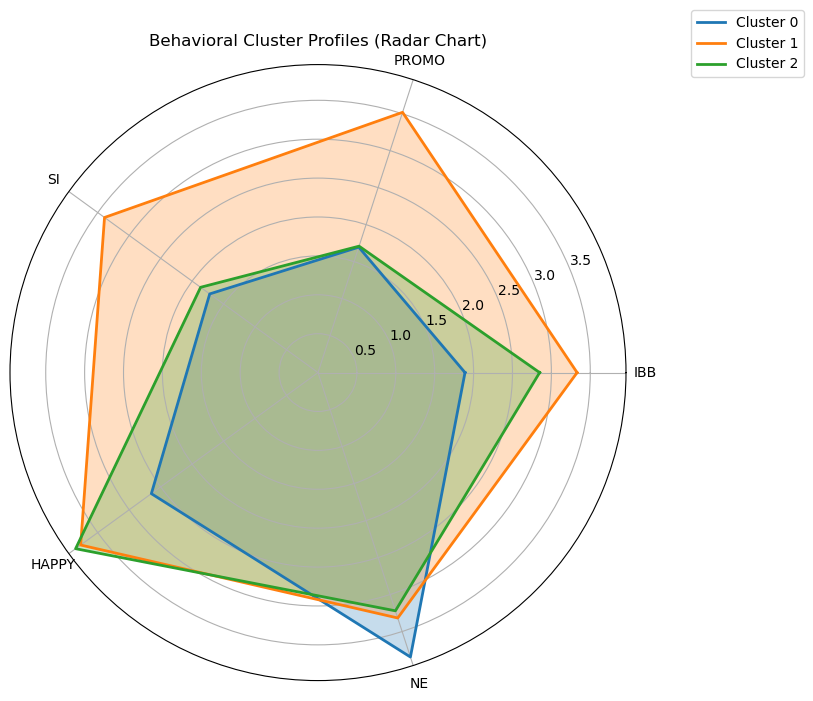

In [139]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['IBB', 'PROMO', 'SI', 'HAPPY', 'NE']
num_vars = len(labels)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f"Cluster {cluster}")
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Behavioral Cluster Profiles (Radar Chart)")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


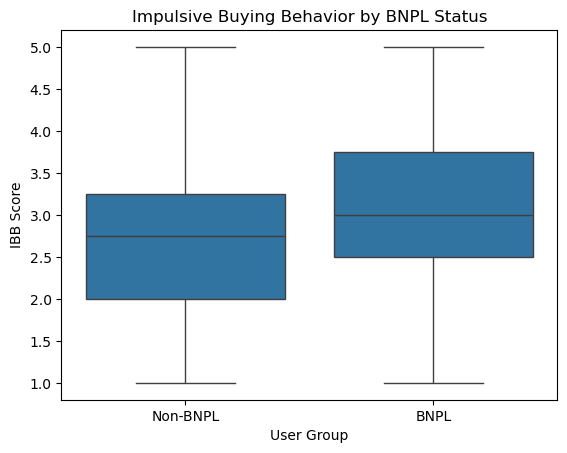

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['bnpl_status'], y=df['IBB'])
plt.xticks([0,1], ['Non-BNPL','BNPL'])
plt.title('Impulsive Buying Behavior by BNPL Status')
plt.ylabel('IBB Score')
plt.xlabel('User Group')
plt.show()
